<a href="https://colab.research.google.com/github/Fatemeh-Rahmani/MEG-Based-Analysis-of-Brain-Responses/blob/main/MEG_Based_Analysis_of_Brain_Responses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Brain signals/MEG/')

In [3]:
!pip install mne

In [4]:
import numpy as np
import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper, tfr_array_morlet, tfr_stockwell
from mne.time_frequency import stft
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq


In [5]:
data_path = '/content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif'
raw = mne.io.read_raw_fif(data_path, preload=True)
print(raw)
print(raw.info)

Opening raw data file /content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif...


<ipython-input-5-9901a6a7080f>:2: RuntimeWarning: This filename (/content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


    Range : 313000 ... 471999 =    313.000 ...   471.999 secs
Ready.
Reading 0 ... 158999  =      0.000 ...   158.999 secs...
<Raw | MNstim_RD_mc.fif, 330 x 159000 (159.0 s), ~405.5 MiB, data loaded>
<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 7 10.000000 500.000000
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 3 Stimulus, 12 misc, 9 Continuous head position indicator (HPI) coil channels
 custom_ref_applied: False
 description: (nursing) Vectorview system at Erasme
 dev_head_t: MEG device -> head transform
 dig: 183 items (3 Cardinal, 4 HPI, 176 Extra)
 events: 1 item (list)
 experimenter: 6611
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2009-10-21 12:13:31 UTC
 meas_id: 4 items (dict)
 nchan: 330
 proc_history: 2 items (list

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3101 samples (3.101 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    5.8s


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


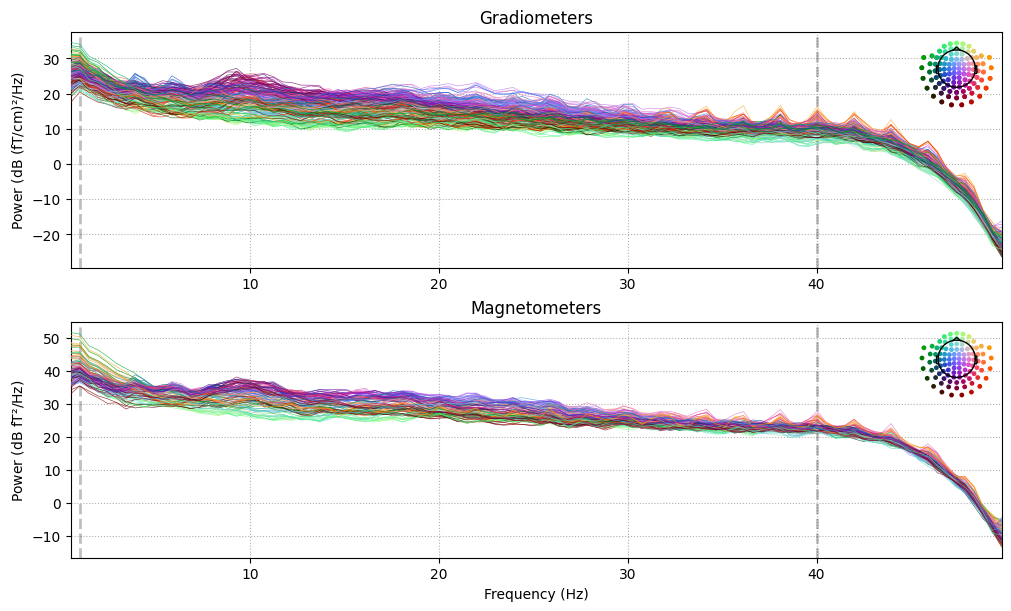

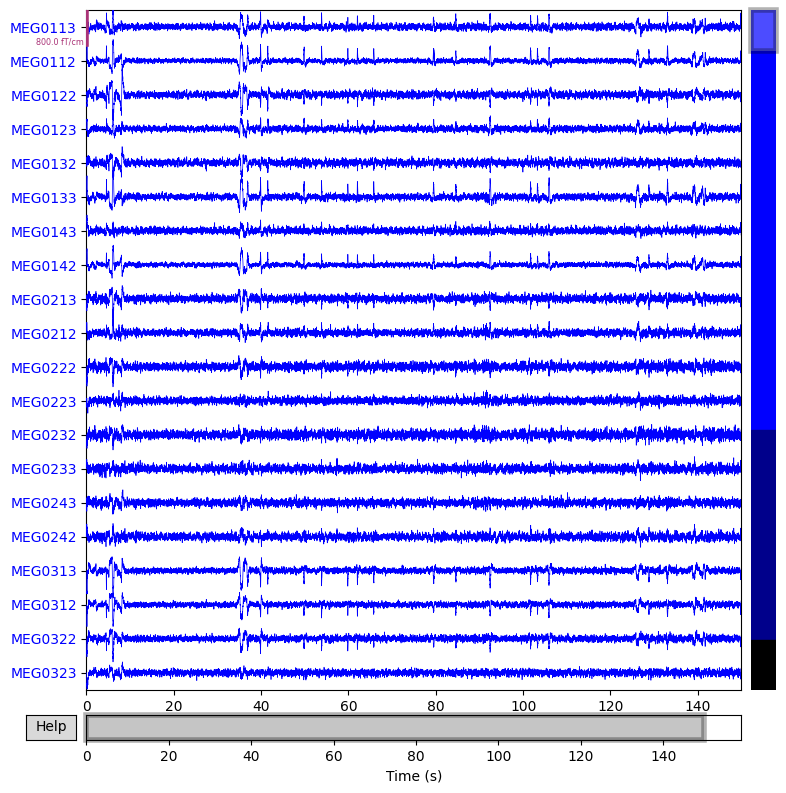

In [6]:
raw.filter(l_freq=1, h_freq=40, fir_window ="hann")
raw.compute_psd(fmin=0.1,fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration = 150)
plt.show()

In [7]:
stim_values = np.unique(raw['STI101'][0])
print(stim_values)

[ 0. 64.]


# gradiometer

304 events found on stim channel STI101
Event IDs: [64]
Not setting metadata
304 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 304 events and 701 original time points ...
1 bad epochs dropped


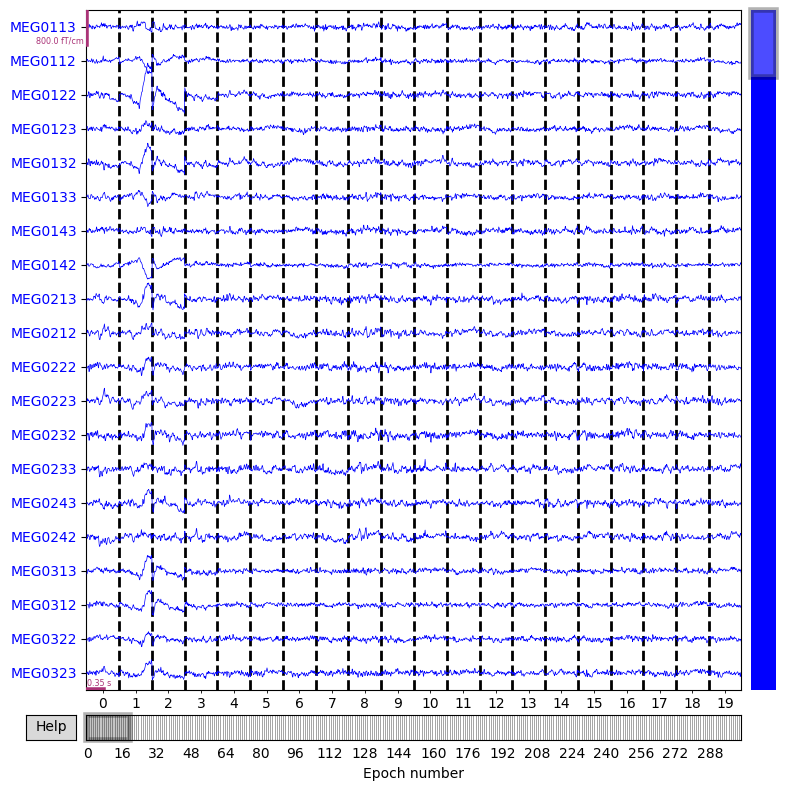

In [8]:
# Select gradiometers
picks = mne.pick_types(raw.info, meg='grad')
events = mne.find_events(raw, stim_channel='STI101')

# Define epochs parameters
event_id = {'stimulation': 64}

tmin = -0.2
tmax = 0.5

# Create epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), preload=True)
epochs.plot()
plt.show()

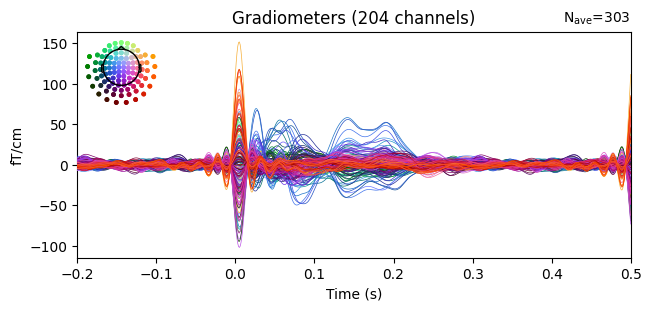

No projector specified for this dataset. Please consider the method self.add_proj.


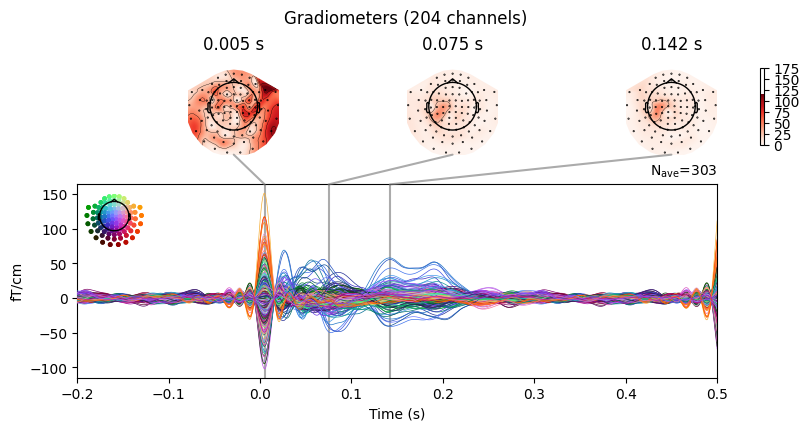

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


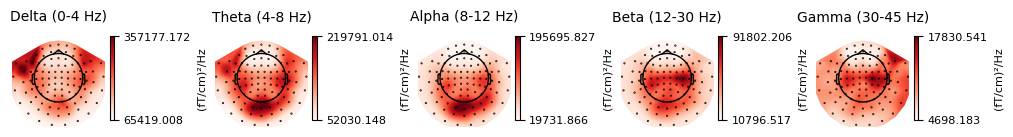

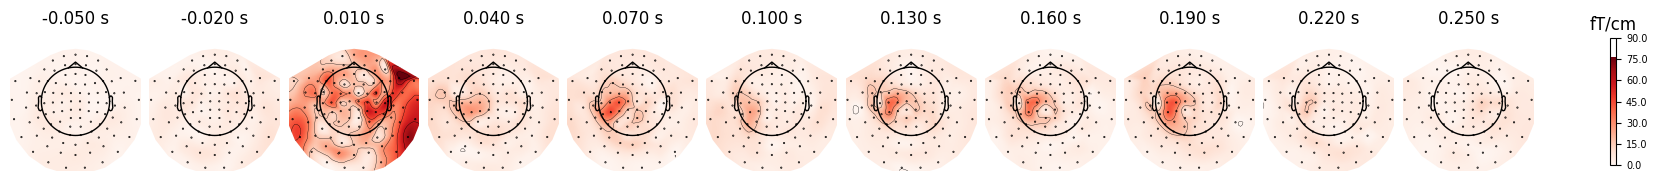

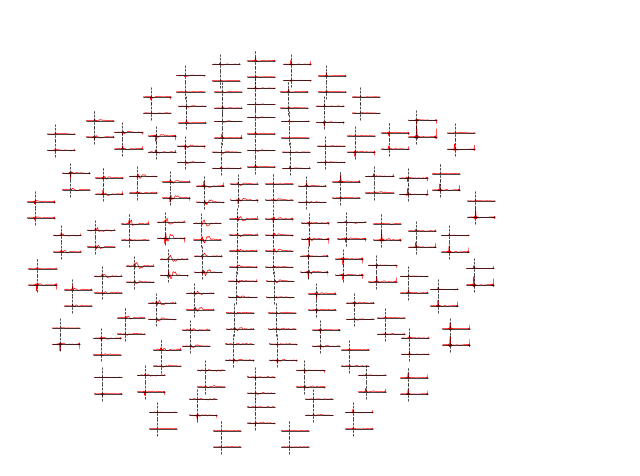

Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
combining channels using RMS (grad channels)


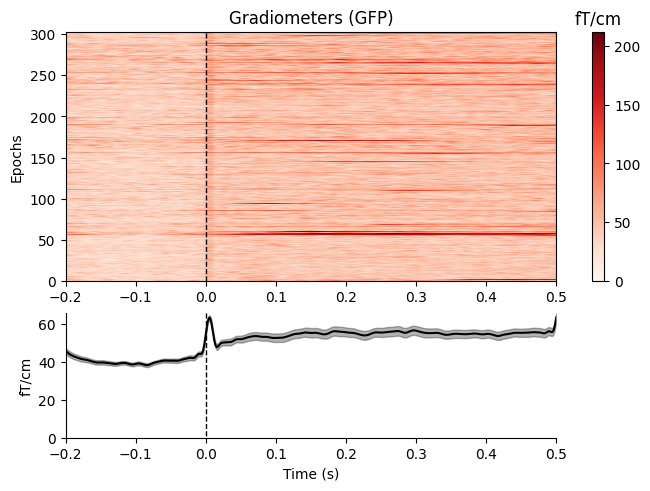

In [9]:
# Average epochs to derive the evoked response
evoked = epochs.average()

# Plot the evoked response
evoked.plot()
evoked.plot_joint()

# plot the spatial distributions of the PSD at frequency bands
spectrum = epochs.compute_psd()
spectrum.plot_topomap(ch_type="grad", normalize=False, contours=0)

# plot the topographical distribution at specific time points
# times_of_interest = [-0.005, 0, 0.005, 0.05, 0.1, 0.076, 0.25, 0.498]
# evoked.plot_topomap(times=times_of_interest, ch_type='grad')

evoked.plot_topomap(times=np.linspace(-0.05, 0.25, 11), ch_type='grad')
evoked.pick(picks="grad").plot_topo(color="r", legend=False)
epochs.plot_image(picks="grad")
plt.show()


In [10]:
raw_grad = raw.copy().pick_types(meg='grad')
names = raw_grad.info['ch_names']
print(names)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
['MEG0113', 'MEG0112', 'MEG0122', 'MEG0123', 'MEG0132', 'MEG0133', 'MEG0143', 'MEG0142', 'MEG0213', 'MEG0212', 'MEG0222', 'MEG0223', 'MEG0232', 'MEG0233', 'MEG0243', 'MEG0242', 'MEG0313', 'MEG0312', 'MEG0322', 'MEG0323', 'MEG0333', 'MEG0332', 'MEG0343', 'MEG0342', 'MEG0413', 'MEG0412', 'MEG0422', 'MEG0423', 'MEG0432', 'MEG0433', 'MEG0443', 'MEG0442', 'MEG0513', 'MEG0512', 'MEG0523', 'MEG0522', 'MEG0532', 'MEG0533', 'MEG0542', 'MEG0543', 'MEG0613', 'MEG0612', 'MEG0622', 'MEG0623', 'MEG0633', 'MEG0632', 'MEG0642', 'MEG0643', 'MEG0713', 'MEG0712', 'MEG0723', 'MEG0722', 'MEG0733', 'MEG0732', 'MEG0743', 'MEG0742', 'MEG0813', 'MEG0812', 'MEG0822', 'MEG0823', 'MEG0913', 'MEG0912', 'MEG0923', 'MEG0922', 'MEG0932', 'MEG0933', 'MEG0942', 'MEG0943', 'MEG1013', 'MEG1012', 'MEG1023', 'MEG1022', 'MEG1032', 'MEG1033', 'MEG1043', 'MEG1042', 'MEG1112', 'MEG1113', 'MEG1123', 'MEG1122', 'MEG1133', 'MEG1132', 'MEG1142', 'MEG1143'

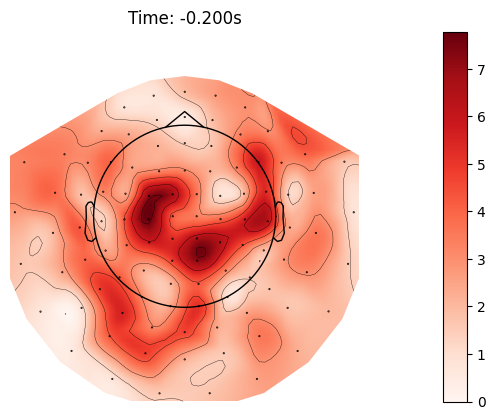

In [11]:
times = np.linspace(-0.2, 0.5, 100)

# Create a figure with three axes
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.9, 0.05]})

# Initial plot
evoked.plot_topomap(ch_type='grad', axes=ax, colorbar=False, show=False)

# Create a colorbar on the second axis
cbar = fig.colorbar(ax.images[0], cax=cbar_ax)

def animate(i):
    ax.clear()
    evoked.plot_topomap(times[i], ch_type='grad', axes=ax, colorbar=False, show=False)
    ax.set_title(f"Time: {times[i]:.3f}s")
    # Update the colorbar limits
    cbar.mappable.set_clim(vmin=ax.images[0].get_clim()[0], vmax=ax.images[0].get_clim()[1])

ani = FuncAnimation(fig, animate, frames=len(times), interval=400)

# Convert the animation to HTML5 video
HTML(ani.to_html5_video())


## Stimulation frequency _ gradiometer

In [12]:
# Identify Stimulus Events
events = mne.find_events(raw, stim_channel='STI101')
stimulus_timings = events[:, 0] / raw.info['sfreq']

# Calculate Inter-Stimulus Intervals (ISI)
isi = np.diff(stimulus_timings)
stimulation_frequency = 1 / np.mean(isi)
print("Stimulation Frequency:", stimulation_frequency, "Hz")


304 events found on stim channel STI101
Event IDs: [64]
Stimulation Frequency: 2.0 Hz


Stimulation frequency: 2.0 Hz


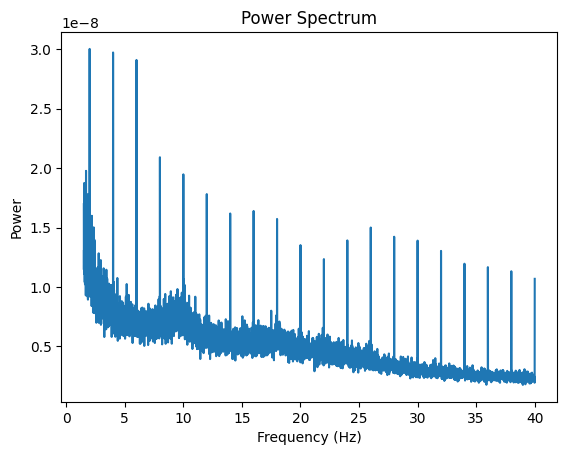

Effective window size : 2.048 (s)


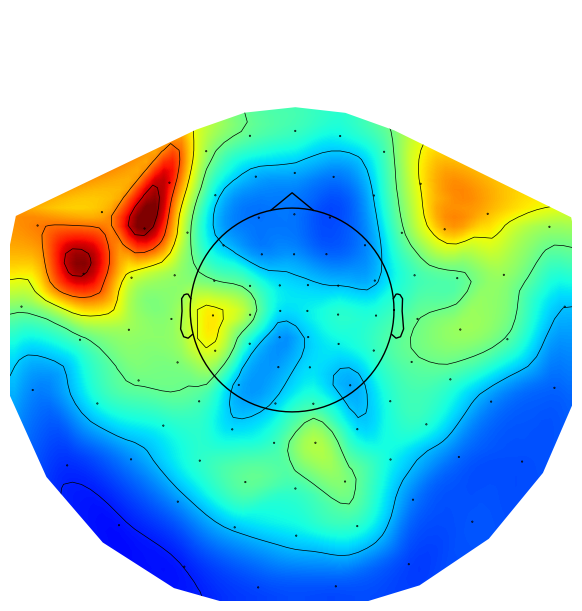

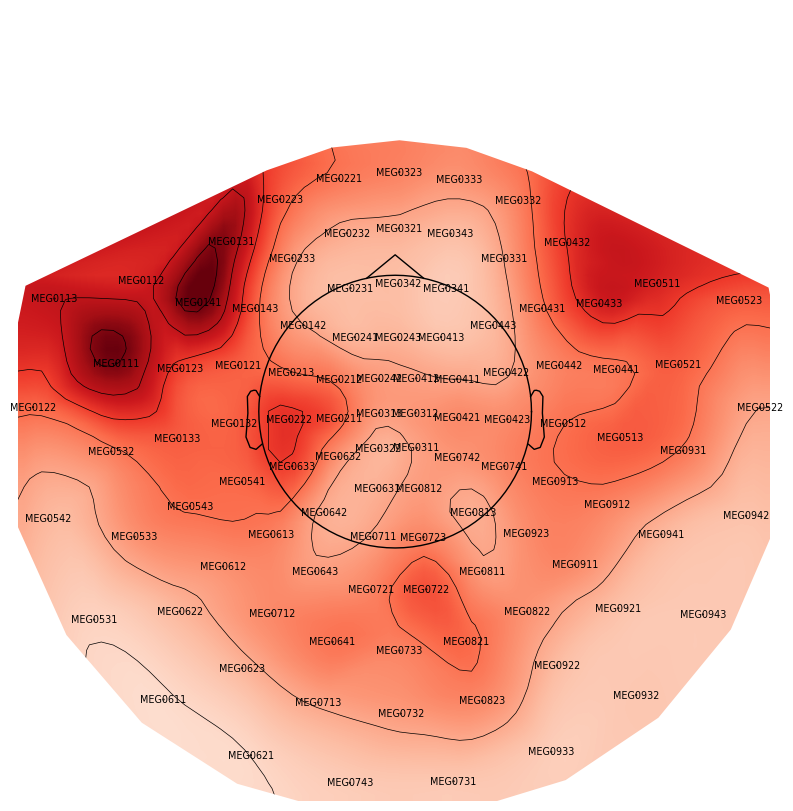

(<matplotlib.image.AxesImage at 0x7d3cbb3a17b0>,
 <matplotlib.contour.QuadContourSet at 0x7d3cbb3a2f20>)

In [13]:
 # Pick gradiometer channels
picks = mne.pick_types(raw.info, meg='grad')

# Get the data and times
data, times = raw[picks]

# Perform Fourier analysis
frequencies = np.fft.fftfreq(data.shape[1], d=1/raw.info['sfreq'])
power = np.abs(np.fft.fft(data, axis=1))

# Take the absolute value of frequencies
freq_range_mask = (frequencies >= 1.5) & (frequencies <= 40)
selected_frequencies = frequencies[freq_range_mask]
selected_power = power[:, freq_range_mask]

# Find the frequency of maximum power
max_power_freq = selected_frequencies[np.argmax(selected_power.mean(axis=0))]
print(f'Stimulation frequency: {max_power_freq} Hz')

# Plot power
plt.plot(selected_frequencies, selected_power.mean(axis=0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.show()


# Power spectral density
psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=raw.info['sfreq'], n_fft=2048, window='bartlett')

# Find the index of the stimulation frequency
stim_freq_idx = np.argmin(np.abs(freqs - max_power_freq))

# Compute the topographical distribution of power at the stimulation frequency
power_topo = psd[:, stim_freq_idx]

# Create a new Info object for gradiometer channels only
info_grad_only = mne.pick_info(raw.info, picks)

# Plot the topographical distribution
mne.viz.plot_topomap(power_topo, info_grad_only, cmap='jet', size=6)

names = raw.info['ch_names']
mne.viz.plot_topomap(power_topo, info_grad_only, names=names, sensors=True, size=8)


In [14]:
freqs = np.logspace(*np.log10([1, 35]), num=8)
n_cycles = freqs / 4.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.9s


Applying baseline correction (mode: logratio)


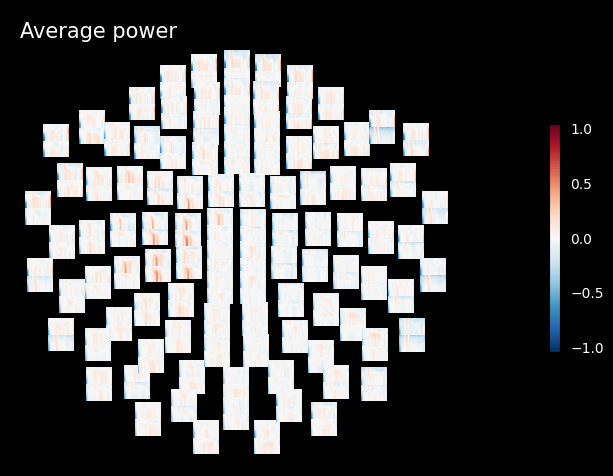

Applying baseline correction (mode: logratio)


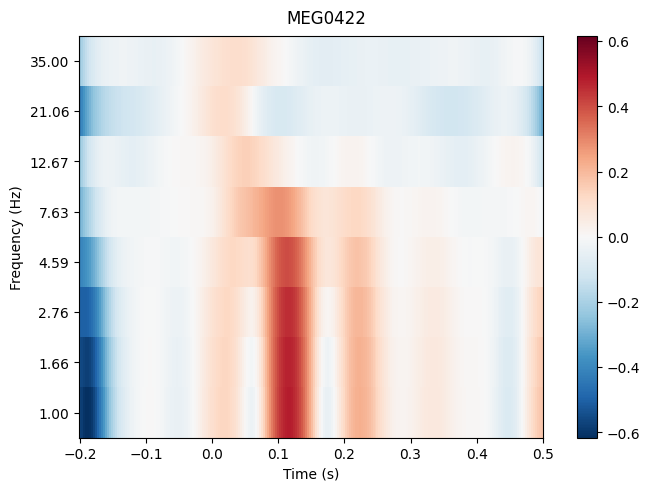

Applying baseline correction (mode: logratio)


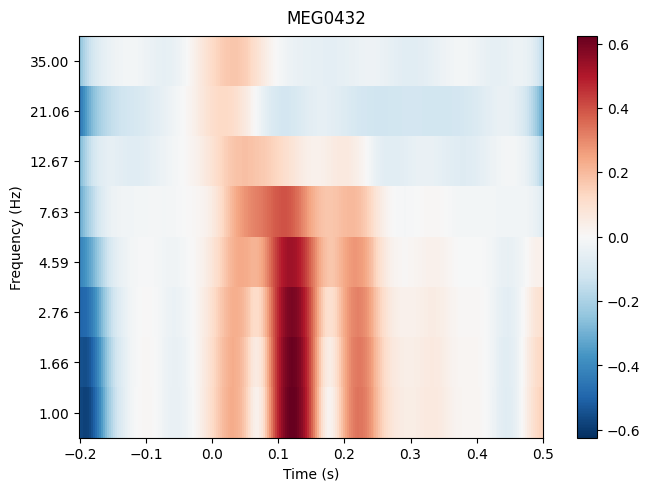

Applying baseline correction (mode: logratio)


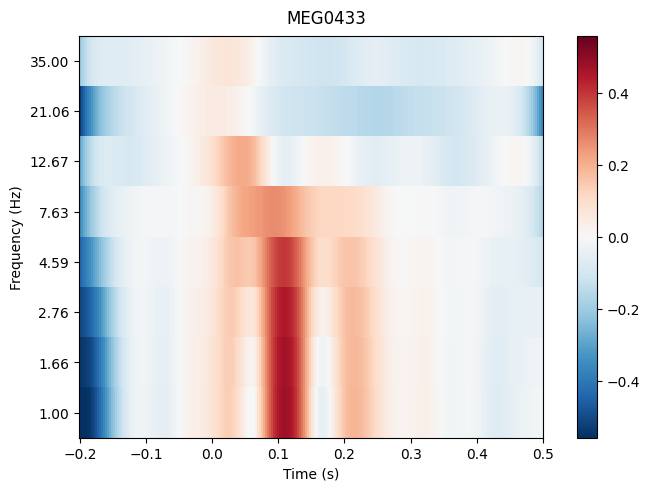

[<Figure size 640x480 with 2 Axes>]

In [15]:
power.plot_topo(baseline=(-0.1, 0), mode="logratio", title="Average power")
power.plot(["MEG0422"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0422")
power.plot(["MEG0432"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0432")
power.plot(["MEG0433"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0433")


# magnetometer

Opening raw data file /content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif...
    Range : 313000 ... 471999 =    313.000 ...   471.999 secs
Ready.
Reading 0 ... 158999  =      0.000 ...   158.999 secs...


<ipython-input-16-c53ed967a80b>:2: RuntimeWarning: This filename (/content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.9s


304 events found on stim channel STI101
Event IDs: [64]
Not setting metadata
304 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 304 events and 701 original time points ...
1 bad epochs dropped


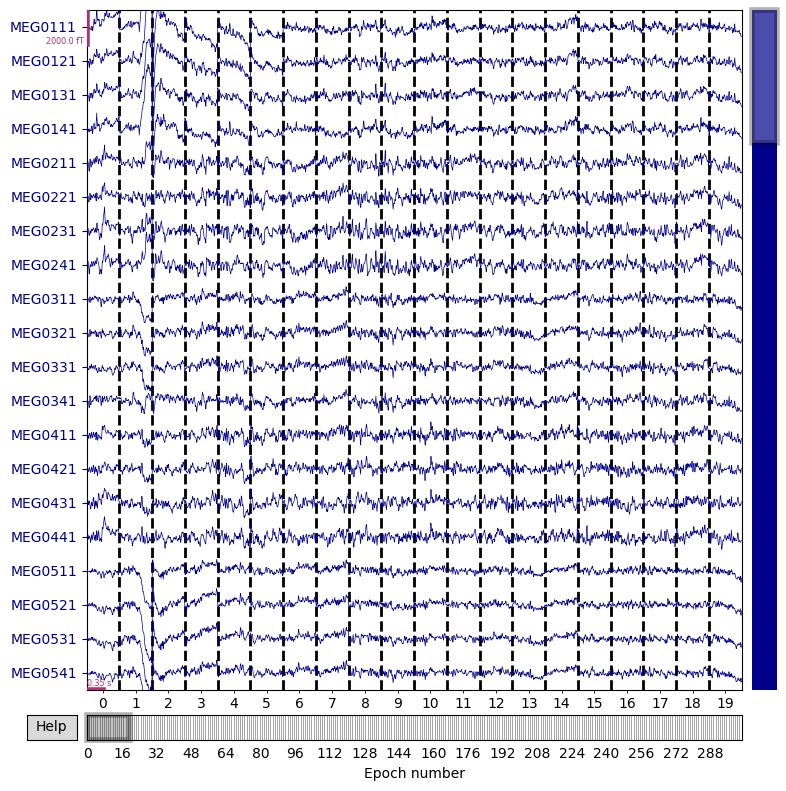

In [16]:
data_path = '/content/drive/My Drive/Brain signals/MEG/MNstim_RD_mc.fif'
raw = mne.io.read_raw_fif(data_path, preload=True)
raw.filter(l_freq=0.1, h_freq=40)

# Select magnetometers
picks = mne.pick_types(raw.info, meg='mag')
events = mne.find_events(raw, stim_channel='STI101')

# Define epochs parameters
event_id = {'stimulation': 64}

tmin = -0.2
tmax = 0.5

# Create epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks, baseline=(None, 0), preload=True)
epochs.plot()
plt.show()

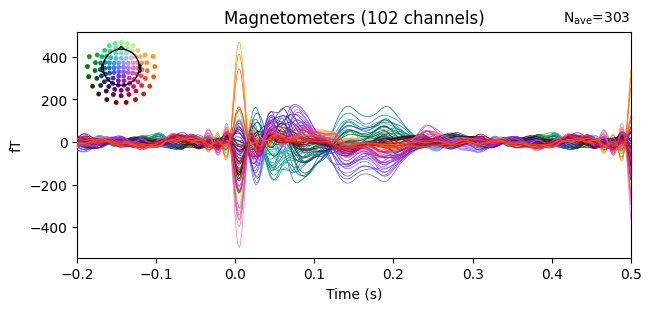

No projector specified for this dataset. Please consider the method self.add_proj.


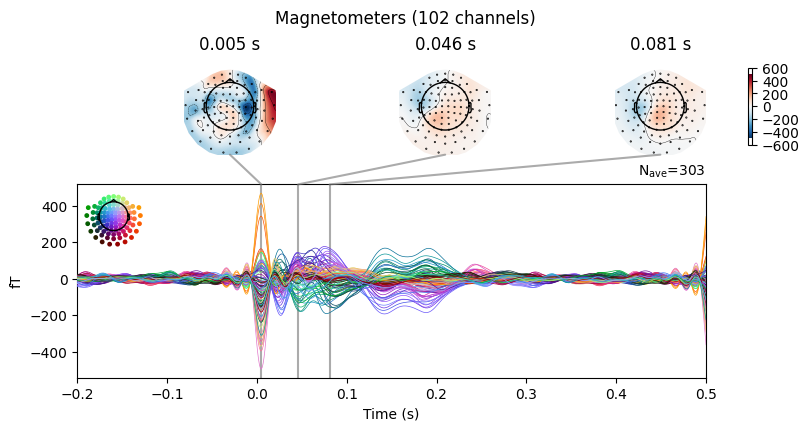

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs before plotting...


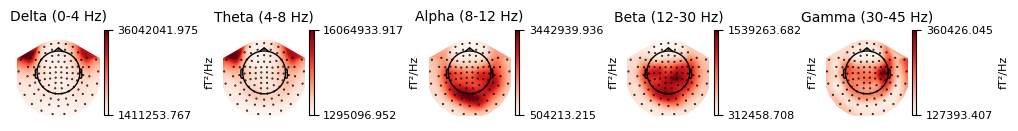

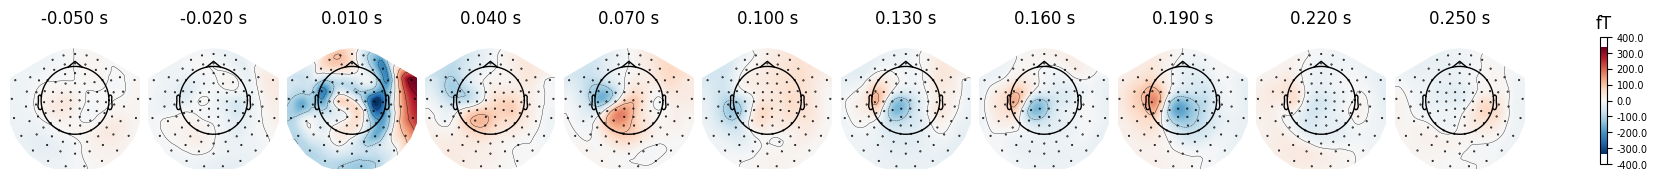

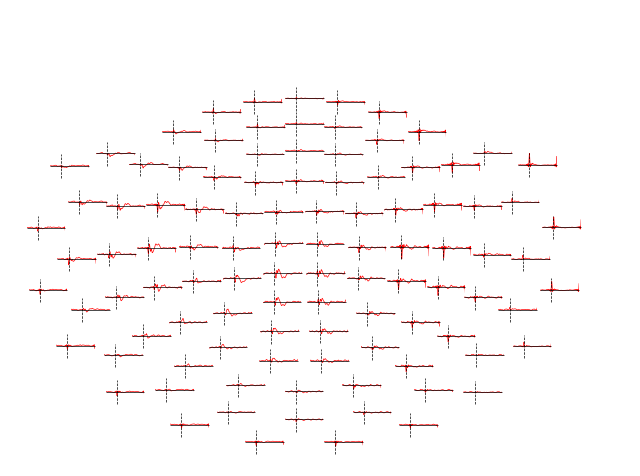

Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
combining channels using RMS (mag channels)


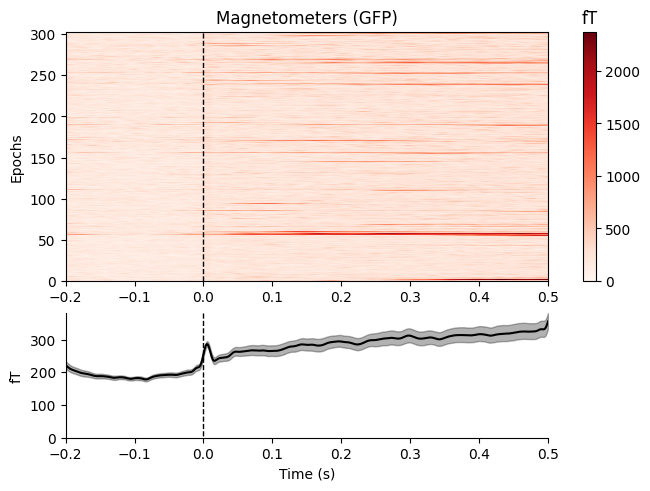

In [17]:
# Average epochs to derive the evoked response
evoked = epochs.average()

# Plot the evoked response
evoked.plot()
evoked.plot_joint()

# plot the spatial distributions of the PSD at frequency bands
spectrum = epochs.compute_psd()
spectrum.plot_topomap(ch_type="mag", normalize=False, contours=0)

# plot the topographical distribution at specific time points
evoked.plot_topomap(times=np.linspace(-0.05, 0.25, 11), ch_type='mag')
evoked.pick(picks="mag").plot_topo(color="r", legend=False)
epochs.plot_image(picks="mag")
plt.show()


In [18]:
raw_grad = raw.copy().pick_types(meg='mag')
names = raw_grad.info['ch_names']
print(names)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
['MEG0111', 'MEG0121', 'MEG0131', 'MEG0141', 'MEG0211', 'MEG0221', 'MEG0231', 'MEG0241', 'MEG0311', 'MEG0321', 'MEG0331', 'MEG0341', 'MEG0411', 'MEG0421', 'MEG0431', 'MEG0441', 'MEG0511', 'MEG0521', 'MEG0531', 'MEG0541', 'MEG0611', 'MEG0621', 'MEG0631', 'MEG0641', 'MEG0711', 'MEG0721', 'MEG0731', 'MEG0741', 'MEG0811', 'MEG0821', 'MEG0911', 'MEG0921', 'MEG0931', 'MEG0941', 'MEG1011', 'MEG1021', 'MEG1031', 'MEG1041', 'MEG1111', 'MEG1121', 'MEG1131', 'MEG1141', 'MEG1211', 'MEG1221', 'MEG1231', 'MEG1241', 'MEG1311', 'MEG1321', 'MEG1331', 'MEG1341', 'MEG1411', 'MEG1421', 'MEG1431', 'MEG1441', 'MEG1511', 'MEG1521', 'MEG1531', 'MEG1541', 'MEG1611', 'MEG1621', 'MEG1631', 'MEG1641', 'MEG1711', 'MEG1721', 'MEG1731', 'MEG1741', 'MEG1811', 'MEG1821', 'MEG1831', 'MEG1841', 'MEG1911', 'MEG1921', 'MEG1931', 'MEG1941', 'MEG2011', 'MEG2021', 'MEG2031', 'MEG2041', 'MEG2111', 'MEG2121', 'MEG2131', 'MEG2141', 'MEG2211', 'MEG2221'

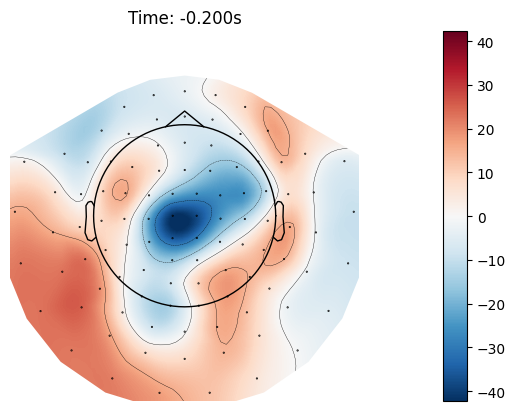

In [19]:
times = np.linspace(-0.2, 0.5, 100)

# Create a figure with three axes
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.9, 0.05]})

# Initial plot
evoked.plot_topomap(ch_type='mag', axes=ax, colorbar=False, show=False)

# Create a colorbar on the second axis
cbar = fig.colorbar(ax.images[0], cax=cbar_ax)

def animate(i):
    ax.clear()
    evoked.plot_topomap(times[i], ch_type='mag', axes=ax, colorbar=False, show=False)
    ax.set_title(f"Time: {times[i]:.3f}s")
    # Update the colorbar limits
    cbar.mappable.set_clim(vmin=ax.images[0].get_clim()[0], vmax=ax.images[0].get_clim()[1])

ani = FuncAnimation(fig, animate, frames=len(times), interval=400)

# Convert the animation to HTML5 video
HTML(ani.to_html5_video())


In [20]:
freqs = np.logspace(*np.log10([1, 35]), num=8)
n_cycles = freqs / 4.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   11.3s


Applying baseline correction (mode: logratio)


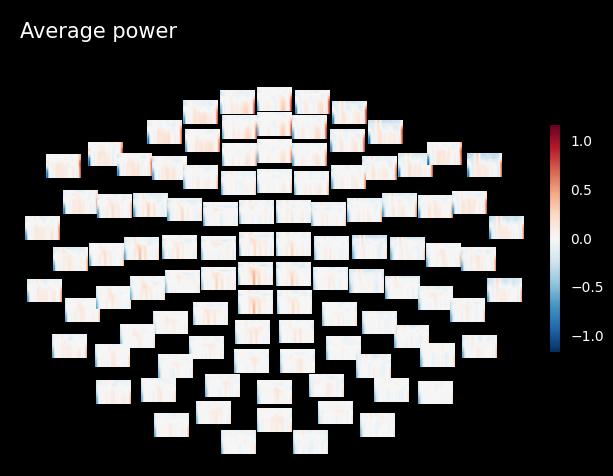

Applying baseline correction (mode: logratio)


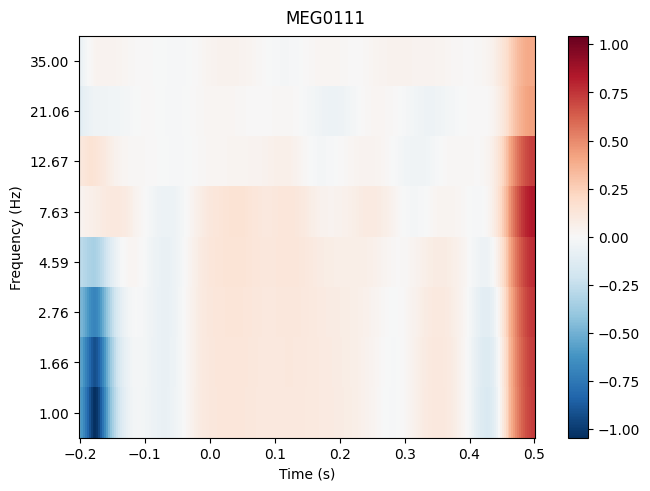

Applying baseline correction (mode: logratio)


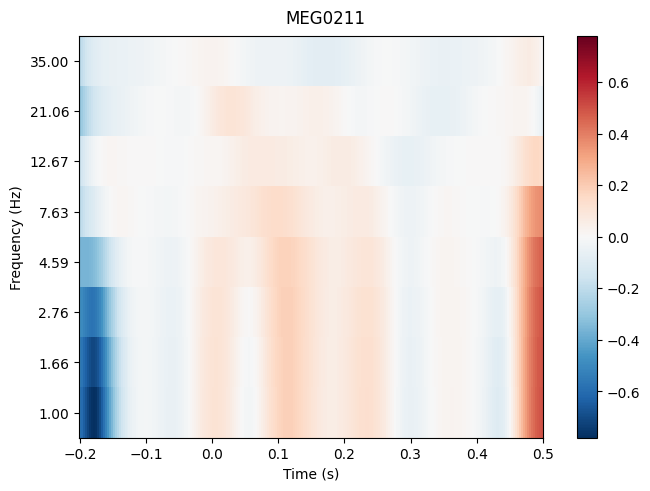

Applying baseline correction (mode: logratio)


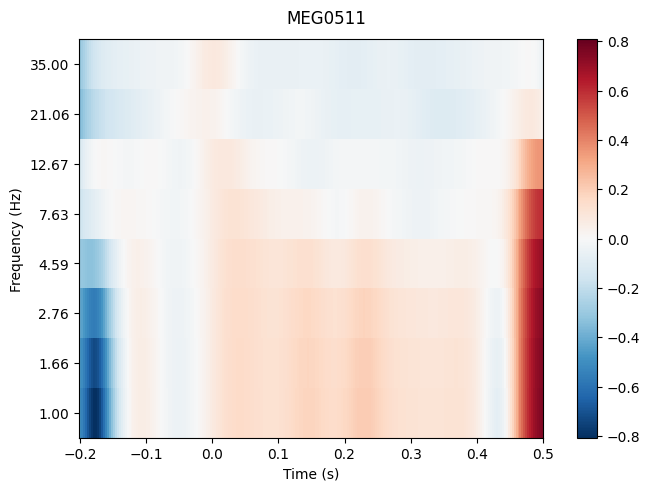

Applying baseline correction (mode: logratio)


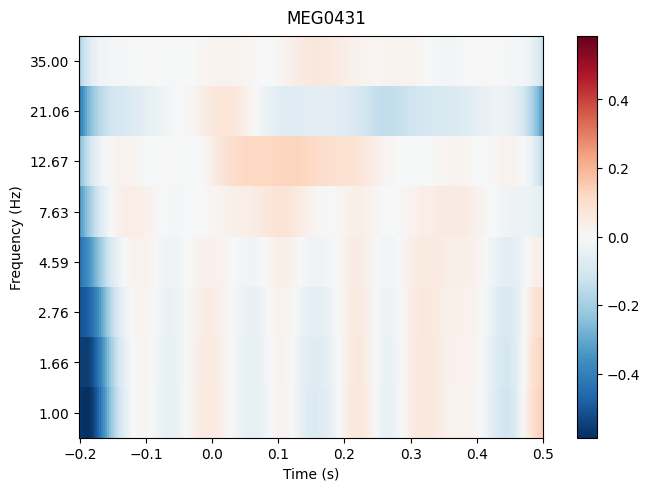

[<Figure size 640x480 with 2 Axes>]

In [21]:
power.plot_topo(baseline=(-0.1, 0), mode="logratio", title="Average power")
power.plot(["MEG0111"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0111")
power.plot(["MEG0211"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0211")
power.plot(["MEG0511"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0511")
power.plot(["MEG0431"], baseline=(-0.1, 0.0), mode="logratio", title="MEG0431")